# imports

In [1]:
!pip install neurokit2 --quiet
!pip install neurokit2 pyhrv --quiet
!pip install pyhrv peakutils --quiet
!pip uninstall -y biosppy pyhrv
!pip install biosppy==0.6.1 pyhrv==0.4.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 47.9 MB/s eta 0:00:00
Found existing installation: biosppy 2.2.3
Uninstalling biosppy-2.2.3:
  Successfully uninstalled biosppy-2.2.3
Found existing installation: pyhrv 0.4.1
Uninstalling pyhrv-0.4.1:
  Successfully uninstalled pyhrv-0.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 5.9 MB/s eta 0:00:00


In [2]:
import neurokit2 as nk
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from scipy.signal import welch
from tensorflow import keras
from pyhrv.frequency_domain import welch_psd
from pyhrv.nonlinear import sample_entropy

# upload data from drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
import keras
import joblib

project_dir = '/content/drive/MyDrive/Colab Notebooks/project/'
trained_models_dir = os.path.join(project_dir, 'trained models/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import pandas as pd
import numpy as np
import re

def load_ecg_segments(base_dir):
    records = []

    for fname in sorted(os.listdir(base_dir)):
        if fname.endswith(".csv") and fname.startswith("ecg_sub"):
            match = re.match(r"ecg_sub(\d+)_seg(\d+)\.csv", fname)
            if match:
                sub = int(match.group(1))
                seg = int(match.group(2))
                file_path = os.path.join(base_dir, fname)

                try:
                    df = pd.read_csv(file_path, header=None)
                    # Get the first column as the signal
                    raw_data = df.iloc[:, 0].dropna().astype(np.float32).tolist()

                    records.append({
                        "sub": sub,
                        "seg": seg,
                        "raw data": raw_data
                    })
                except Exception as e:
                    print(f"⚠️ Error reading {fname}: {e}")

    return pd.DataFrame(records)

In [6]:
import ast
project_dir = '/content/drive/MyDrive/Colab Notebooks/project/'
save_dir = project_dir + 'Integration and simulation/'

base_dir = project_dir+'Integration and simulation/ecg_for_check'

#df1 = load_ecg_segments(base_dir)
original_df = pd.read_csv(save_dir+'ecg_segments_loaded.csv')
df = original_df.copy()
df["raw data"] = df["raw data"].apply(ast.literal_eval)

# Sanity check
#df.head()
#print(df.columns)

'''# prompt: lets save into a directory in drive df

save_dir = project_dir + 'Integration and simulation/'
#os.makedirs(save_dir, exist_ok=True)
df.to_csv(save_dir + 'ecg_segments_loaded.csv', index=False)'''

"# prompt: lets save into a directory in drive df\n\nsave_dir = project_dir + 'Integration and simulation/'\n#os.makedirs(save_dir, exist_ok=True)\ndf.to_csv(save_dir + 'ecg_segments_loaded.csv', index=False)"

In [7]:
df.head()

,sub,seg,raw data
0,10,1,"[-2.0, -2.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1,10,2,"[-18.0, -22.0, -26.0, -25.0, -10.0, 45.0, 127...."
2,10,3,"[0.0, 1.0, 5.0, 12.0, 16.0, 16.0, 17.0, 18.0, ..."
3,10,4,"[18.0, 15.0, 14.0, 14.0, 17.0, 19.0, 13.0, 7.0..."
4,10,5,"[83.0, 111.0, 130.0, 126.0, 102.0, 51.0, -13.0..."


# main

In [8]:
# ========= MAIN EXECUTION =========
# Sampling rate (Hz) — update based on your dataset
fs = 250

ecg = df.iloc[9, 2]  # Extract ECG column and ensure float type

# Data processint and plot

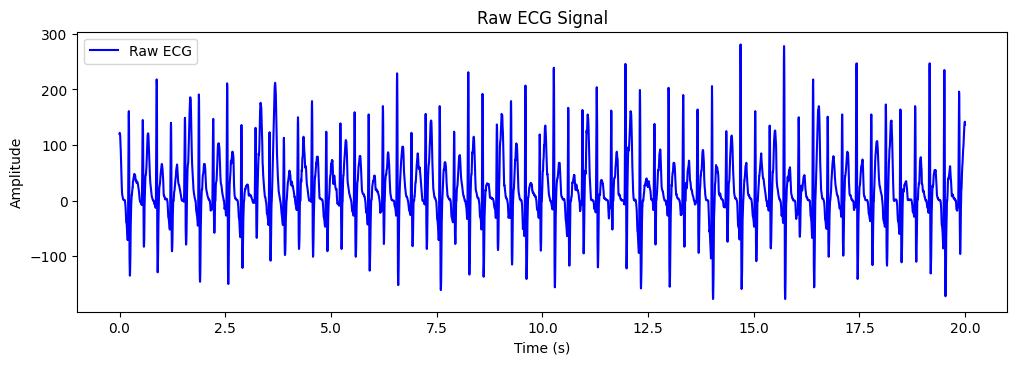

In [9]:
def plot_raw_and_processed_ecg(raw_signal, fs):
    times = np.arange(len(raw_signal)) / fs
    plt.figure(figsize=(12, 8))
    # Plot 1: Raw ECG
    plt.subplot(2, 1, 1)
    plt.plot(times, raw_signal, label="Raw ECG", color='blue')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Raw ECG Signal")
    plt.legend()
    plt.show()
plot_raw_and_processed_ecg(ecg, fs)

# Data Analysis

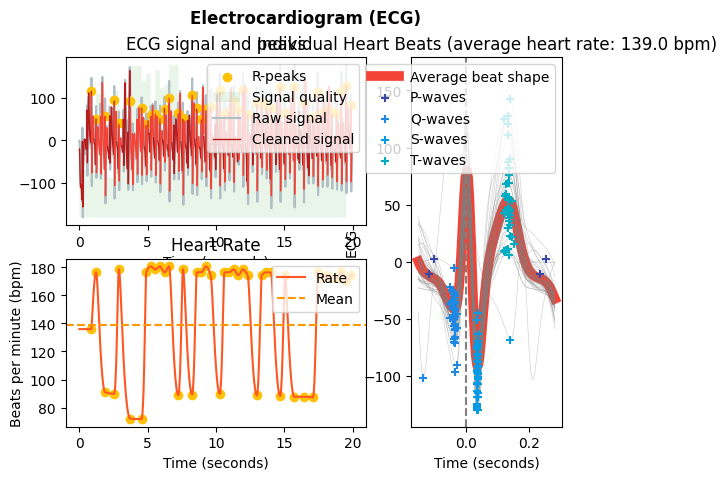

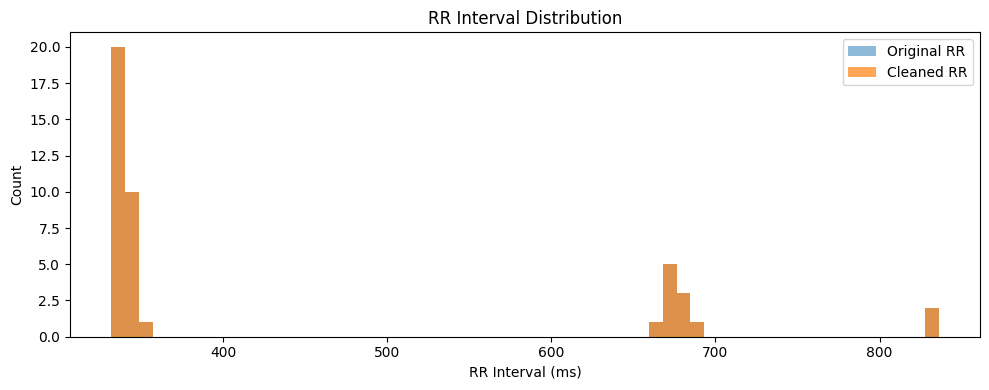

🔹 NeuroKit2 HRV Time-Domain:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  441.302326  167.22889         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  221.522868  224.208071  ...      324.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.754906        337.6        670.4  37.209302  37.209302      332.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0      836.0   2.6875       0.0  

[1 rows x 25 columns]
   HRV_ULF  HRV_VLF  HRV_LF   HRV_HF   HRV_VHF    HRV_TP  HRV_LFHF  HRV_LFn  \
0      NaN      NaN     NaN  0.14937  0.029533  0.178903       NaN      NaN   

   HRV_HFn  HRV_LnHF  
0  0.83492 -1.901332  

🔹 pyHRV Time-Domain (Using NeuroKit2 results):
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  441.302326  167.22889         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  

In [10]:
# === 2. Clean ECG Signal ===
ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=fs)

# === 3. Detect R-peaks and Process Signal ===
ecg_signals, info = nk.ecg_process(ecg_cleaned, sampling_rate=fs)
rpeaks = info["ECG_R_Peaks"]
rr_intervals = np.diff(rpeaks) / fs * 1000  # RR intervals in ms

# === 4. Remove Extreme RR Values ===
rr_clean = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 2000)]

# === 5. Visualize ECG with R-peaks ===
nk.ecg_plot(ecg_signals, info)

# === 6. Visualize RR Distribution ===
plt.figure(figsize=(10, 4))
plt.hist(rr_intervals, bins=60, alpha=0.5, label='Original RR')
plt.hist(rr_clean, bins=60, alpha=0.7, label='Cleaned RR')
plt.xlabel("RR Interval (ms)")
plt.ylabel("Count")
plt.title("RR Interval Distribution")
plt.legend()
plt.tight_layout()
plt.show()

# === 7. HRV Analysis with NeuroKit2 ===
print("🔹 NeuroKit2 HRV Time-Domain:")
hrv_time_results = nk.hrv_time(ecg_signals, sampling_rate=fs)  # Store results
print(hrv_time_results)
print(nk.hrv_frequency(ecg_signals, sampling_rate=fs))

# === 8. HRV Analysis with pyHRV ===
# Convert clean RR intervals to pyHRV-compatible format
rr_list = rr_clean.tolist()

# print("\n🔹 pyHRV Time-Domain:")  # Comment out the pyHRV Time-Domain calculations
# td_results = td.time_domain(rr_list)  # Comment out pyHRV calculation
# print(td_results)  # Comment out to avoid error

# Instead, print NeuroKit2 Time-Domain HRV
print("\n🔹 pyHRV Time-Domain (Using NeuroKit2 results):")
print(hrv_time_results)  # Use results from NeuroKit2




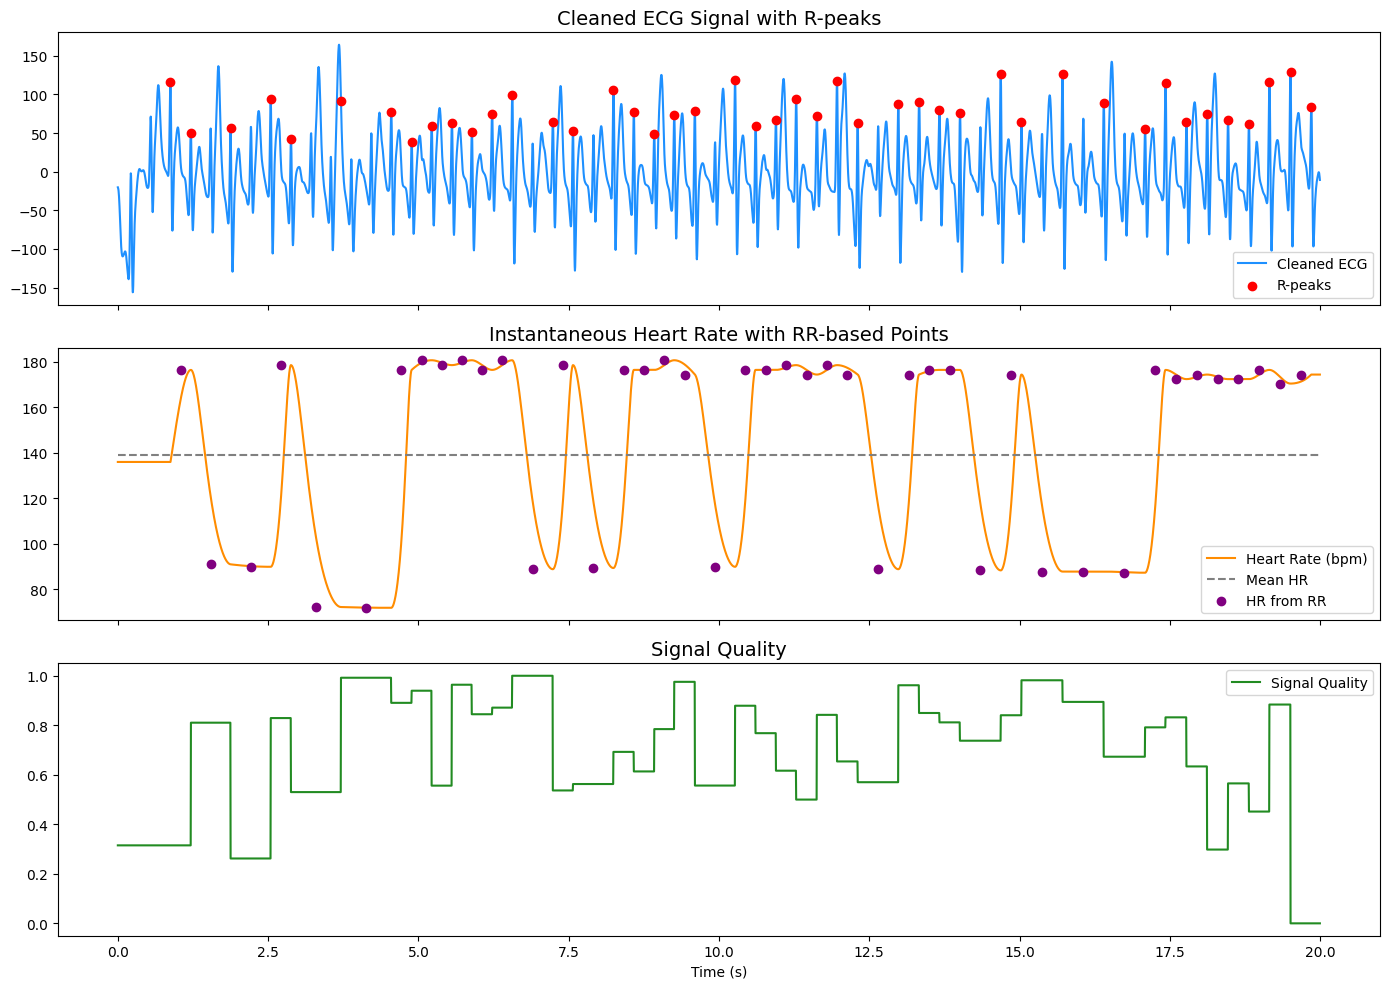

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def plot_custom_ecg_with_rpeaks(ecg_signals, info, fs):
    rpeaks = info["ECG_R_Peaks"]
    times = np.arange(len(ecg_signals)) / fs
    heart_rate = ecg_signals["ECG_Rate"]

    # Time positions for heart rate values (midpoint between R-peaks)
    rpeaks_sec = rpeaks / fs
    hr_times = (rpeaks_sec[1:] + rpeaks_sec[:-1]) / 2  # Midpoints for RR intervals

    # Plot setup
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # 1. Cleaned ECG signal
    axs[0].plot(times, ecg_signals["ECG_Clean"], color="dodgerblue", label="Cleaned ECG")
    axs[0].scatter(rpeaks_sec, ecg_signals["ECG_Clean"].iloc[rpeaks], color="red", label="R-peaks", zorder=5)
    axs[0].set_title("Cleaned ECG Signal with R-peaks", fontsize=14)
    axs[0].legend()

    # 2. Heart Rate with R-peak midpoints
    axs[1].plot(times, heart_rate, color="darkorange", label="Heart Rate (bpm)")
    axs[1].hlines(np.mean(heart_rate), xmin=0, xmax=times[-1], linestyle="--", color="gray", label="Mean HR")
    axs[1].scatter(hr_times, heart_rate.iloc[rpeaks[1:]], color="purple", label="HR from RR", zorder=5)
    axs[1].set_title("Instantaneous Heart Rate with RR-based Points", fontsize=14)
    axs[1].legend()

    # 3. Signal Quality
    quality = ecg_signals["ECG_Quality"]
    axs[2].plot(times, quality, color="forestgreen", label="Signal Quality")
    axs[2].set_title("Signal Quality", fontsize=14)
    axs[2].legend()

    axs[2].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


plot_custom_ecg_with_rpeaks(ecg_signals, info, fs)


https://zenodo.org/records/5727800

# New Section

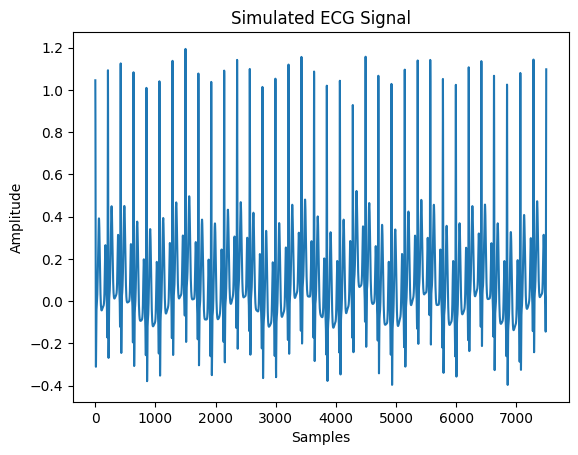

In [58]:

import matplotlib.pyplot as plt

# Simulate ECG signal
ecg_signal = nk.ecg_simulate(duration=30, noise=0.01, heart_rate=70, sampling_rate=250)

# Plot the signal
plt.plot(ecg_signal)
plt.title("Simulated ECG Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()



   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  857.818182  12.692159         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN  13.619838  13.809183  ...         inf    3.387696   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD   HRV_HFD  HRV_KFD  \
0      1.57988       NaN        NaN         NaN  2.445622  2.060664  2.95126   

    HRV_LZC  
0  1.070023  

[1 rows x 82 columns]


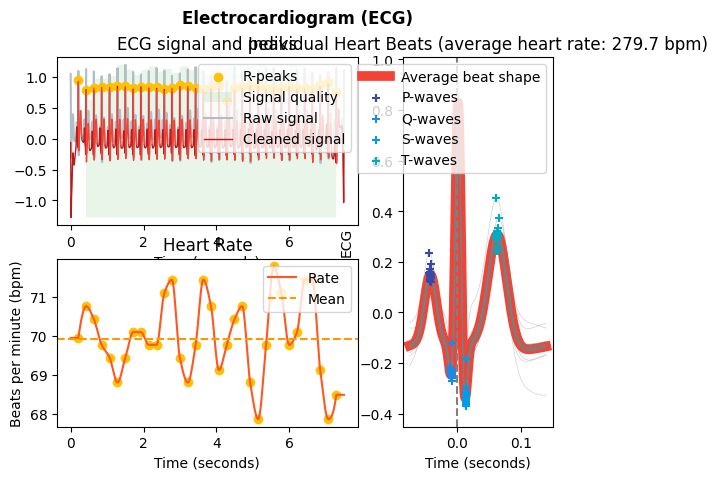

In [59]:
import neurokit2 as nk

# Process ECG signal to get peaks and rate
signals, info = nk.ecg_process(ecg_signal, sampling_rate=250)

# Plot processed signal
nk.ecg_plot(signals)

# Get HRV features
hrv = nk.hrv(signals, sampling_rate=250)
print(hrv)



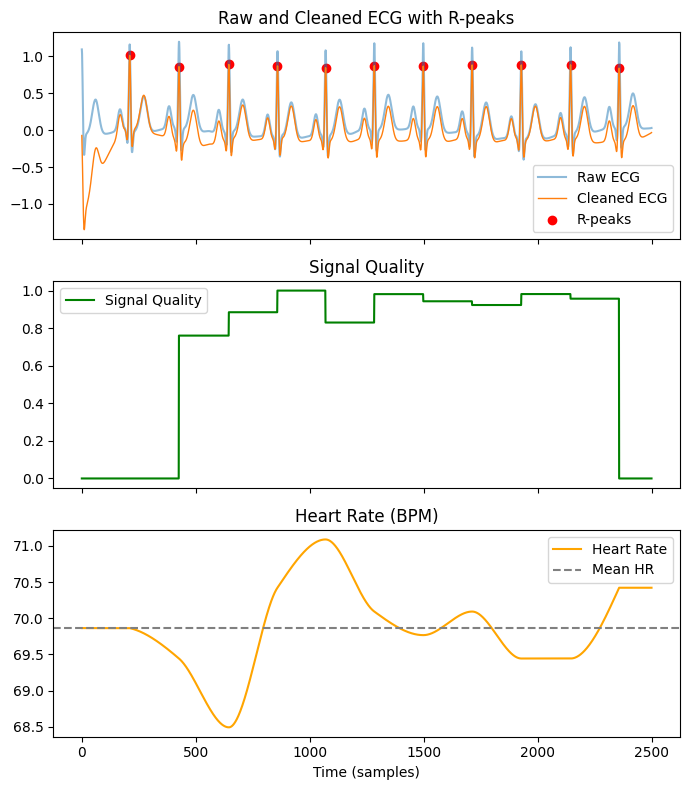

In [70]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Simulate ECG
ecg_signal = nk.ecg_simulate(duration=10, noise=0.01, heart_rate=70, sampling_rate=250)
signals, info = nk.ecg_process(ecg_signal, sampling_rate=250)

# Create individual subplots
fig, axs = plt.subplots(3, 1, figsize=(7, 8), sharex=True)

# 1. Raw and Cleaned ECG + R-peaks
axs[0].plot(signals["ECG_Raw"], label="Raw ECG", alpha=0.5)
axs[0].plot(signals["ECG_Clean"], label="Cleaned ECG", linewidth=1)
axs[0].scatter(signals.index[signals["ECG_R_Peaks"] == 1],
               signals["ECG_Clean"][signals["ECG_R_Peaks"] == 1],
               color='red', label="R-peaks")
axs[0].legend()
axs[0].set_title("Raw and Cleaned ECG with R-peaks")

# 2. Signal Quality (optional)
if "ECG_Quality" in signals.columns:
    axs[1].plot(signals["ECG_Quality"], label="Signal Quality", color="green")
    axs[1].legend()
    axs[1].set_title("Signal Quality")

# 3. Heart Rate
axs[2].plot(signals["ECG_Rate"], label="Heart Rate", color="orange")
axs[2].axhline(signals["ECG_Rate"].mean(), linestyle='--', color='gray', label='Mean HR')
axs[2].legend()
axs[2].set_title("Heart Rate (BPM)")
axs[2].set_xlabel("Time (samples)")

plt.tight_layout()
plt.show()



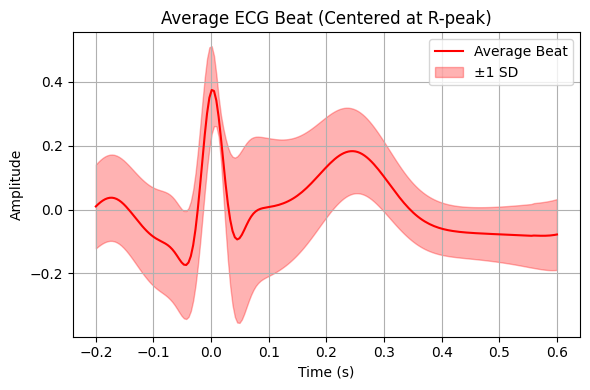

In [69]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Simulate ECG signal
ecg_signal = nk.ecg_simulate(duration=10, noise=0.01, heart_rate=70, sampling_rate=250)

# Process the ECG signal
signals, info = nk.ecg_process(ecg_signal, sampling_rate=250)

# Create epochs around R-peaks
epochs = nk.epochs_create(signals, events=info["ECG_R_Peaks"], sampling_rate=250, epochs_start=-0.2, epochs_end=0.6)

# Extract just the ECG_Clean signal from each epoch
ecg_beats = []
for epoch in epochs.values():
    if "ECG_Clean" in epoch.columns:
        ecg_beats.append(epoch["ECG_Clean"].reset_index(drop=True))

# Align lengths in case of small mismatches
min_len = min(len(b) for b in ecg_beats)
ecg_beats = [b[:min_len] for b in ecg_beats]

# Create DataFrame where each column is one beat
beats_df = pd.DataFrame(ecg_beats).T

# Compute average and standard deviation
average_beat = beats_df.mean(axis=1)
std_beat = beats_df.std(axis=1)
time = np.linspace(-0.2, 0.6, len(average_beat))  # time axis in seconds

# Plot
plt.figure(figsize=(6, 4))
plt.plot(time, average_beat, label="Average Beat", color="red")
plt.fill_between(time, average_beat - std_beat, average_beat + std_beat,
                 color="red", alpha=0.3, label="±1 SD")
plt.title("Average ECG Beat (Centered at R-peak)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




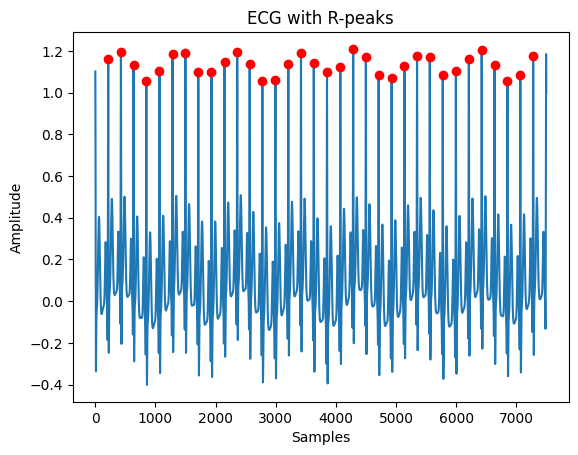

In [24]:
# R-peaks location
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=250)
r_locs = rpeaks['ECG_R_Peaks']

# Plot with R-peaks
plt.plot(ecg_signal)
plt.plot(r_locs, ecg_signal[r_locs], 'ro')
plt.title("ECG with R-peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

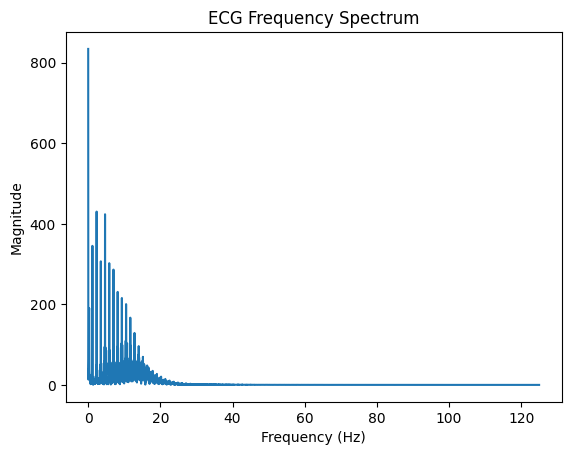

In [25]:
import numpy as np

fft = np.fft.fft(ecg_signal)
freq = np.fft.fftfreq(len(fft), d=1/250)

plt.plot(freq[:len(freq)//2], np.abs(fft[:len(freq)//2]))
plt.title("ECG Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()
